In [12]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from datetime import date

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [13]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 20:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [14]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [15]:
BASE_URL = 'https://finance.yahoo.com' #Global Variable 

def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #time
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'url' : BASE_URL + news_url,
            'content' : news_content,
           }

In [16]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [17]:
# url = 'https://finance.yahoo.com/topic/stock-market-news/'
# doc = get_page(url)
# news_list = get_news_tags(doc)
# news_list

## Entire Stock Market News

In [18]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = BASE_URL + '/topic/stock-market-news/'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2022-12-15
Report Time = 13:51:30


In [19]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [20]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [21]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [22]:
news_df[news_df['Score'] > 0.8]

,source,time,headline,url,content,Sentiment,Score,Sentiment2,Score2
0,Investor's Business Daily,2 minutes ago,"Dow Jones Falls On Rate Jitters, Retail Sales; EV Outlook Dims; Solar ETF On Watch",https://finance.yahoo.com/m/7594b1b9-631f-352d-805f-6faca85abbd5/dow-jones-falls-on-rate.html,Dow Jones falls on hawkish Fed Powell remarks that signal a peak rate of 5.1%. Retail sales fall. EV stocks fall on dim outlook; TAN on watch,NEGATIVE,0.999635,NEGATIVE,0.999537
1,Bloomberg,7 minutes ago,Nikola CEO Sells $17.2 Million of Stock in the Months Leading to Retirement,https://finance.yahoo.com/news/nikola-ceo-sells-17-2-175637673.html,"(Bloomberg) -- Nikola Corp.’s former chief executive officer has sold more than a third of his direct stock holdings since the electric-truck maker announced his retirement after the end of this year.Most Read from BloombergIs Putin Finally Getting Smart About His Ukraine Disaster?Elon Musk’s Tesla Share Sales Approach the $40 Billion MarkPowell Says Fed Still Has a ‘Ways to Go’ After Half-Point HikeThis Is the World’s Biggest Stock Winner of 2022 With 1,600% GainMark Russell has offloaded just",NEGATIVE,0.947763,NEGATIVE,0.992225
3,MarketWatch,20 minutes ago,"Dow tumbles over 900 points, S&P 500 sheds 2.8% as stocks hit session lows in afternoon trade",https://finance.yahoo.com/m/a41dd1ed-380b-3923-8499-e87b35b84943/dow-tumbles-over-900-points-.html,"U.S. stock indexes extended losses in early afternoon trade Thursday on worries that the Federal Reserve's relentless interest rate hikes will tip the economy into a recession. The Dow Jones Industrial Average fell 927 points, or 2.7%, to 33,042, on track to book its biggest daily decline in over two months. The S&P 500 slumped 2.8%, while the Nasdaq Composite dropped 3.4%, both heading for their worst days since September. The Federal Reserve hiked its interest rate by half a percentage poi...",NEGATIVE,0.998178,NEGATIVE,0.999534
4,MarketWatch,30 minutes ago,‘The Fed is going to overdo it’: Financial markets react to U.S. central bank’s 2023 rate outlook and weak data,https://finance.yahoo.com/m/90ce3d1e-c787-37b8-b30d-3200b0f55f67/%E2%80%98the-fed-is-going-to-overdo.html,"Financial markets are still absorbing the Federal Reserve's stridently hawkish interest-rate outlook for 2023, plus fresh signs of a weakening U.S. economy",NEGATIVE,0.999301,POSITIVE,0.989069
5,MarketWatch,30 minutes ago,"Dow skids nearly 950 points, stocks hit session lows in afternoon trade",https://finance.yahoo.com/m/0bae6827-288f-3def-a5e0-0859950a970d/dow-skids-nearly-950-points-.html,"U.S. stocks tumble on Thursday early afternoon, adding to the previous day's losses, a day after the Federal Reserve raised rates and revived recession worries.",NEGATIVE,0.994169,NEGATIVE,0.998871
6,The Wall Street Journal,31 minutes ago,Dow Falls More Than 900 Points on Interest-Rate Expectations,https://finance.yahoo.com/m/0f03afd7-2ad3-3672-96c3-6f44957f07f3/dow-falls-more-than-900.html,U.S. stocks fell a day after the Federal Reserve signaled plans to lift interest rates through the spring.,NEGATIVE,0.999368,NEGATIVE,0.999638
7,Bloomberg,34 minutes ago,Stocks Push Lower as Traders Digest Rate Moves: Markets Wrap,https://finance.yahoo.com/news/asian-stocks-open-lower-hawkish-224244888.html,"(Bloomberg) -- Stocks across global financial markets were pummeled after a wave of rate hikes from central banks, with the Federal Reserve and the European Central Bank warning of more pain to come. Most Read from BloombergIs Putin Finally Getting Smart About His Ukraine Disaster?Elon Musk’s Tesla Share Sales Approach the $40 Billion MarkPowell Says Fed Still Has a ‘Ways to Go’ After Half-Point HikeThis Is the World’s Biggest Stock Winner of 2022 With 1,600% GainUS equities hit session lows in",NEGATIVE,0.993602,NEGATIVE,0.995497
8,MarketWatch,42 minutes ago,"AMD stock named Morgan Stanley’s top chip pick, but not out of ‘enthusiasm’",https://finance.yahoo.com/m/b2231dda-7a2c-3af1-8a83-0b8bb7b720f9/amd-st

### Sentiment of Headline

Text(0.5, 1.0, 'Sentiment of Headline')

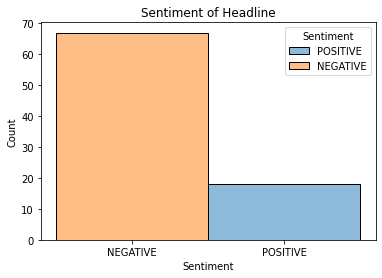

In [25]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Headline")

### Sentiment of Content

Text(0.5, 1.0, 'Sentiment of Content')

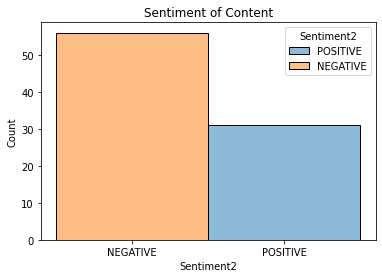

In [26]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Content")

In [27]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [ ]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)


## Each Articles

In [31]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [41]:
url = "https://finviz.com/news.ashx"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    project_href = [i['href'] for i in soup.find_all('a', href=True)]

    for tag in soup.find_all('a', href=True):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [43]:
df = pd.DataFrame(sentence2)

In [50]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])
df['Links'] = project_href

KeyError: 0

In [46]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [47]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [49]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [ ]:
df[df['Score'] > 0.8]